In [8]:
# 生成训练集txt
# Author: Y Chen

In [37]:
import numpy as np
import pandas as pd
import glob
import sys

In [4]:
from PIL import Image
import cv2

In [36]:
from tqdm import tqdm
from pathlib import Path

### 0.API

In [34]:
id_standard_df = pd.read_csv('/nas/chenyi/datasets_nas/labelMap/standard/id2class99_chenyi.csv')
id_use_df = id_standard_df[id_standard_df['use']>=0]

In [91]:
shbg_map = pd.read_excel('./dada_det/data/shoe_bag11k_map.xlsx')

In [13]:
# with open('./data/haowei34k_map_stand.json', 'w') as f:
#     json.dump(hw2stand, f)

In [4]:
def get_list2dict(k_list, v_list):
    d = {}
    for item in zip(k_list, v_list):
        d[item[0]] = item[1]
    return d

In [8]:
model_label_map = {
    0: 10,  # 鞋子
    1: 8,  # 包包
    2: 4,  # 上装
    3: 5,  # 裤子
    4: 6,  # 裙子
    5: 7,  # 连体装
}

In [17]:
l2_map_l1 = get_list2dict( id_use_df['label99'].values, id_use_df['label_l1'].values)

In [18]:
id2chi_l2 = get_list2dict(id_use_df['label2_chi'].values, id_use_df['label99'].values)

In [19]:
id2eng_l2 = get_list2dict(id_use_df['label99'].values, id_use_df['label2_eng'].values)

In [20]:
id2chi_l1 = get_list2dict(id_use_df['label_l1'].values, id_use_df['label1_chi'].values)

In [21]:
id2eng_l1 = get_list2dict(id_use_df['label_l1'].values, id_use_df['label1_eng'].values)

In [22]:
id2model_l1 = get_list2dict(model_label_map.values(), model_label_map.keys())

In [92]:
shbg_map_dict = get_list2dict(shbg_map[shbg_map.columns[0]], shbg_map[shbg_map.columns[1]])

### 1.Dataset Information.

In [9]:
# 训练路径.
!tree -d -L 1 /home/chenyi/workspace/yolov5/datasets/

/home/chenyi/workspace/yolov5/datasets/
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_1_june
├── dadet100kv4_june
├── dadet_gallv4_june
├── dadetv5
├── dadetv5_query
├── dadetv6_1
├── dadetv6_2
├── dadetv6_3
├── dataExps
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia70k
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

23 directories


In [10]:
# 图片路径.
!tree -d -L 2 /home/chenyi/workspace/dataset/data/dada_det/

/home/chenyi/workspace/dataset/data/dada_det/
├── hard_sample_0610
│   └── @eaDir
├── shoe_bag11k_may
│   ├── bag_setdiff
│   ├── leisure_shoe_setdiff
│   └── suit_shoe_setdiff
├── shoeBag5k0515
│   └── images
└── wholebody0601_all
    ├── beidaiku2822_rename
    └── liantiku2500_0602_rename

11 directories


#### nas xml

In [40]:
root_nas = Path('/nas/chenyi/datasets_nas/gallery2m_clred/gallery2m_7k20220715/')
# root_nas = Path('/nas/chenyi/datasets_nas/deploy_system/info_csv/')
!ls $root_nas/'csv'

gall7k_label_20220715.csv  gall7k_xml_test_20220715.csv
gall7k_xml_20220715.csv


In [14]:
root_xml = root_nas /'xml_rewrite'
# root_xml = root_nas /'xml_july'
!ls $root_xml

part1_img_xml  part2_img_xml  part3_img_xml  part4_img_xml  part5_img_xml


#### csv读取和保存

In [19]:
root_csv = root_nas /'csv'
xml_df = pd.read_csv(root_csv /'gall7k_xml_20220715.csv')
len(xml_df)

26341

In [20]:
xml_df.head(1)

,xml_path,width,height,labelimg,bx1,bx2,bx3,bx4,stem,img_sp,man,label9,label_eng
0,../../dada_data/gallery2m_clr_july/xml_labelim...,1279,1706,包包,440,596,664,1028,0d99bc28-a05b-11ec-8062-5cfb3aa6f5e6,../../dada_data/gallery2m_clr_july/xml_labelim...,part1_img_xml,1.0,bag


In [23]:
xml_df.value_counts('label_eng')

label_eng
shoe           10008
upper_short     5623
bag             3304
paints          2843
upper_long      1132
wholebody        948
paints_hot       736
miniskirt        723
dtype: int64

### 2.统计数据集

In [26]:
df = xml_df[xml_df['label9']>=0]

In [27]:
df.describe()

,width,height,bx1,bx2,bx3,bx4,label9
count,25317.000000,25317.000000,25317.00000,25317.000000,25317.000000,25317.000000,25317.000000
mean,894.515187,1186.131295,354.72951,679.452581,536.564403,943.461232,1.799068
std,309.812007,385.826830,168.32474,395.004886,216.703441,385.294472,2.142690
min,220.000000,283.000000,1.00000,1.000000,83.000000,66.000000,0.000000
25%,690.000000,920.000000,234.00000,369.000000,384.000000,652.000000,0.000000
50%,690.000000,1035.000000,317.00000,612.000000,471.000000,889.000000,1.000000
75%,1279.000000,1705.000000,451.00000,884.000000,687.000000,1138.000000,3.000000
max,2880.000000,3840.000000,1286.00000,2705.000000,2282.000000,3840.000000,8.000000


#### 二级标签

In [38]:
import matplotlib.pyplot as plt

In [29]:
counter = df.value_counts('label_eng').sort_index()

In [32]:
counter

label_eng
bag             3304
miniskirt        723
paints          2843
paints_hot       736
shoe           10008
upper_long      1132
upper_short     5623
wholebody        948
dtype: int64

In [31]:
numbers

array([ 3304,   723,  2843,   736, 10008,  1132,  5623,   948])

In [33]:
id_list = np.array(counter.axes)[0]
numbers = counter.values
name_list = list(counter.index)

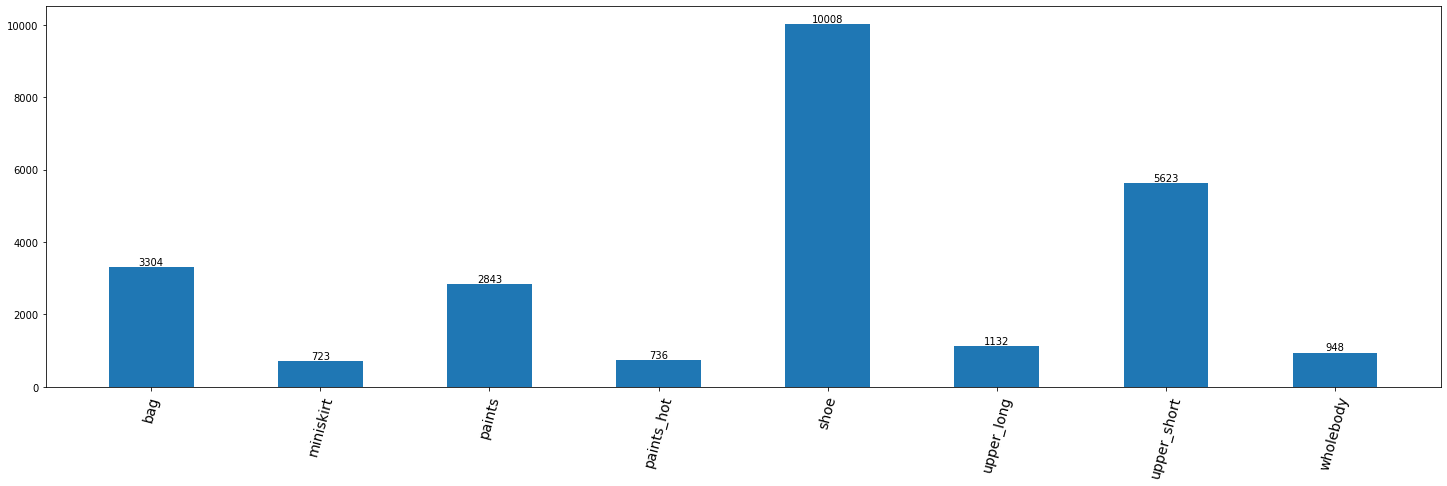

In [39]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=75, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

#### 一级标签

In [ ]:
counter = df.value_counts('label_model').sort_index()

In [ ]:
id2model_l1

In [ ]:
id2eng_l1

{-1: 'other-1',
 4: 'upperbody',
 5: 'pants',
 6: 'skirt',
 7: 'wholebody',
 8: 'bag',
 10: 'shoe'}

In [ ]:
id_list = np.array(counter.axes)[0]
numbers = counter.values
name_list = [str(x) + ':' + id2eng_l1[model_label_map[x]] for x in id_list]

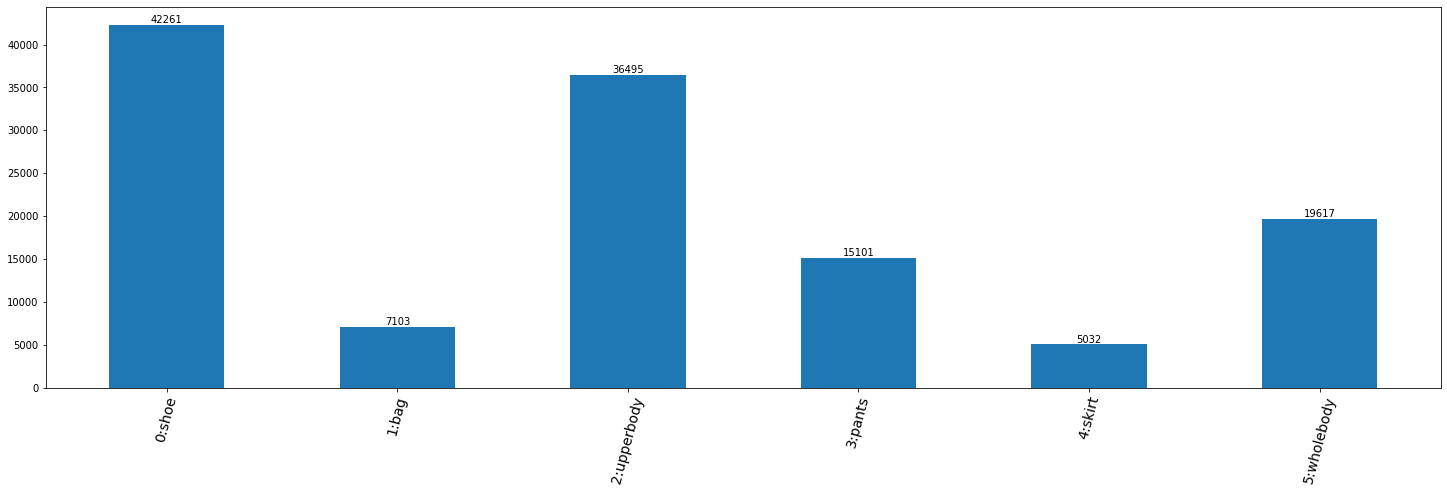

In [ ]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=75, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

In [ ]:
!ls /nas/chenyi/dataset_apparel_nas/

haowei34k  haowei34k_conf7.csv	haowei34k.tar  haowei_conf07_multi  openfashion


In [ ]:
hw_data_p = '/nas/chenyi/dataset_apparel_nas/haowei34k_conf7.csv'

In [ ]:
hw_data_df = pd.read_csv(hw_data_p)

In [ ]:
hw_data_df.head()

,id,img_path,label_path,label_1,一级分类,label_2,二级分类,x_c,y_c,w,h,confidence
0,20141215090521289,/nas/lichangjian/ok_data/20141215090521289.jpg,/nas/lichangjian/labels/20141215090521289.txt,4,上装,0,小西装,0.454839,0.320250,0.412903,0.362912,0.961302
1,20141215090521289,/nas/lichangjian/ok_data/20141215090521289.jpg,/nas/lichangjian/labels/20141215090521289.txt,5,裤子,18,休闲裤,0.440323,0.627986,0.296774,0.470990,0.953829
2,20140924211054180,/nas/lichangjian/ok_data/20140924211054180.jpg,/nas/lichangjian/labels/20140924211054180.txt,4,上装,0,小西装,0.542500,0.343897,0.198333,0.387324,0.920288
3,20140924211054180,/nas/lichangjian/ok_data/20140924211054180.jpg,/nas/lichangjian/labels/20140924211054180.txt,5,裤子,16,西装裤,0.538333,0.660798,0.156667,0.485915,0.915438
4,20141204122102902,/nas/lichangjian/ok_data/20141204122102902.jpg,/nas/lichangjian/labels/20141204122102902.txt,4,上装,4,夹克/外套,0.486250,0.341667,0.322500,0.286667,0.781202


In [ ]:
counter_hw = hw_data_df['label_2'].value_counts()

In [ ]:
id_list = np.array(counter_hw.axes)[0]
numbers = counter_hw.values
name_list = [str(x) + ':' + names[x][1] for x in id_list]

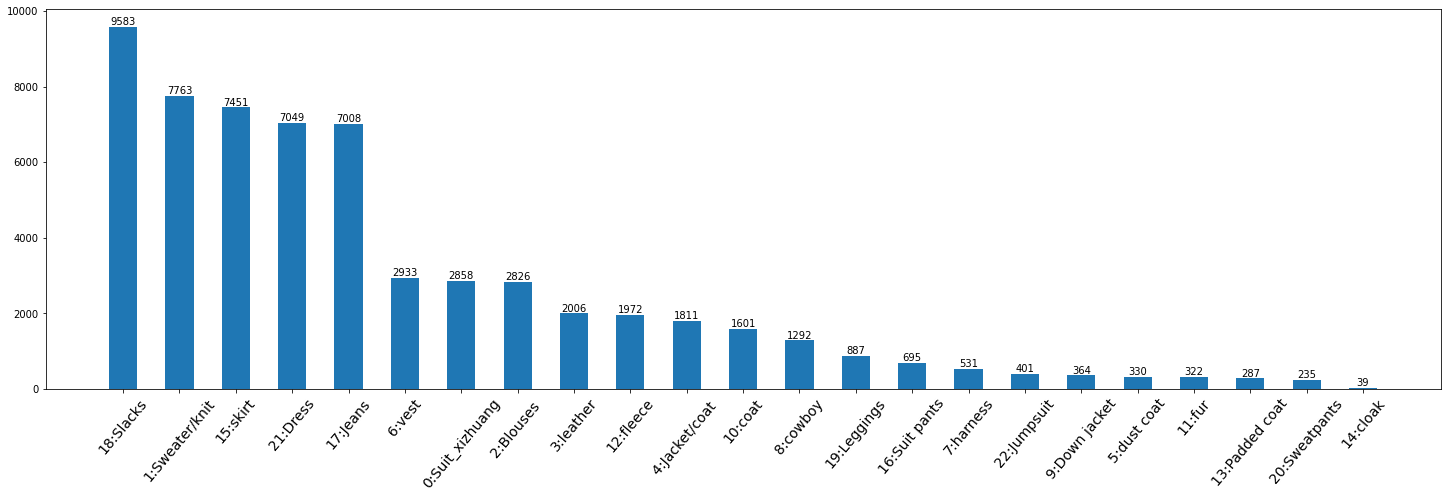

In [ ]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=50, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

### slink_df构建:生成软连接的path

In [13]:
def folder_change(chg_df, origin_folder, folder_name):
    chg_df['img_tp'] = chg_df['img_tp'].apply(lambda x:x.replace(f'/datasets/{origin_folder}/images/', f'/datasets/{folder_name}/images/'))
    chg_df['label_tp'] = chg_df['label_tp'].apply(lambda x:x.replace(f'/datasets/{origin_folder}/labels/', f'/datasets/{folder_name}/labels/'))
    return chg_df

In [14]:
def name_change(chg_df, folder_name):
    chg_df['img_tp'] = chg_df['img_tp'].apply(lambda x: '{0}/{1}_{2}'.format(Path(x).parent, folder_name, Path(x).name))
    chg_df['label_tp'] = chg_df['label_tp'].apply(lambda x: '{0}/{1}_{2}'.format(Path(x).parent, folder_name, Path(x).name))
    return chg_df

In [7]:
# 软连接
root_slink = Path('/nas/chenyi/workspace/myPyModule/dataset/data/slink')
!ls $root_slink/dadet100k

dadet100kv2_slink_df.csv	 dadet100kv4_june_slink_df.csv
dadet100kv3_june_slink_df.csv	 dadet_gallv4_june_slink_df.csv
dadet100kv4_1_june_slink_df.csv


In [5]:
root_yolo = '/home/chenyi/workspace/yolov5/datasets/'
!tree -d -L 1 $root_yolo

/home/chenyi/workspace/yolov5/datasets/
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_1_june
├── dadet100kv4_june
├── dadet_gallv4_june
├── dadetv5
├── dadetv5_query
├── dadetv6_1
├── dataExps
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia70k
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

21 directories


In [490]:
# name_stand = ['img_sp', 'img_tp', 'label_sp', 'label_tp']
# slink_df.rename(columns={slink_df.columns[4]:name_stand[0],
#                         slink_df.columns[3]:name_stand[1],
#                         slink_df.columns[1]:name_stand[2],
#                         slink_df.columns[2]:name_stand[3]},
#                inplace=True)

#### 批量读取slink_df.csv

In [7]:
fashion_slink = pd.read_csv('../fashionpedia/data/fashionpedia6_slink.csv')
hw_slink = pd.read_csv('../haowei34k/data/hw34k_level1_slink.csv')

In [11]:
# shbg5k_slink = pd.read_csv('../dada_det/data/shoeBag5k0515/shoeBag0515_slink_df.csv')
# shbg11k_slink = pd.read_csv('../dada_det/data/shoeBag10k0530/shoe_bag11k_may_slink.csv')
skirt5k_slink = pd.read_csv('../deepfashion2/data/skirt_slink.csv')
wholebody5k_slink = pd.read_csv('../dada_det/data/wholebody5k0610/wholebody5k_slin_dfk.csv')
# syserror_slink = pd.read_csv('../dada_det/data/sys_error_sample/sys_error_slin_dfk.csv')
# len(shbg5k_slink), len(skirt5k_slink), len(shbg11k_slink), len(wholebody5k_slink)

In [15]:
origin_folder = 'hwpedia80k'
folder_name = 'dadet_gallv4_june'
fashion_slink = folder_change(fashion_slink, origin_folder, folder_name)

In [16]:
origin_folder = 'dadet100kv2'
folder_name = 'dadet_gallv4_june'
hw_slink = folder_change(hw_slink, origin_folder, folder_name)

In [18]:
origin_folder = 'dadet100kv1'
folder_name = 'dadet_gallv4_june'
skirt5k_slink = folder_change(skirt5k_slink, origin_folder, folder_name)

In [66]:
origin_folder = 'dadet100kv1'
folder_name = 'dadet100kv4_june'
shbg11k_slink = folder_change(shbg11k_slink, origin_folder, folder_name)

In [20]:
origin_folder = 'dadet100kv3_june'
folder_name = 'dadet_gallv4_june'
wholebody5k_slink = folder_change(wholebody5k_slink, origin_folder, folder_name)

In [232]:
origin_folder = 'dadet100kv3_june'
folder_name = 'dadet_gallv4_june'
syserror_slink = folder_change(syserror_slink, origin_folder, folder_name)
syserror_slink = name_change(syserror_slink, 'syserror60')

#### 单个slink

In [18]:
slink_df = pd.read_csv(root_slink /'dadet100k/dadet100kv4_1_june_slink_df.csv')

/tmp/ipykernel_1210112/170413747.py:1: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  slink_df = pd.read_csv(root_slink /'dadet100k/dadet100kv4_1_june_slink_df.csv')


In [19]:
slink_df.head(1).values

array([['0002ec21ddb8477e98b2cbb87ea2e269',
        '/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt',
        '/home/chenyi/workspace/yolov5/datasets/dadet100kv4_1_june/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt',
        '/home/chenyi/workspace/yolov5/datasets/dadet100kv4_1_june/images/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg',
        '/home/chenyi/workspace/dataset/data/data_fashionpedia/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg',
        nan, 'dadet100kv4_1_june', nan]], dtype=object)

In [20]:
slink_df.head(1)

,fname,label_sp,label_tp,img_tp,img_sp,mode,target,stem
0,0002ec21ddb8477e98b2cbb87ea2e269,/home/chenyi/workspace/dataset/labels/labels6/...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/dataset/data/data_fashi...,NaN,dadet100kv4_1_june,NaN


In [21]:
origin_folder = 'dadet100kv4_1_june'
folder_name = 'dadetv6_1'
slink_df = folder_change(slink_df, origin_folder, folder_name)

In [27]:
# 采样
# slink_train = slink_df[slink_df['mode']=='train']
# slink_val = slink_df[slink_df['mode']=='val']
# # slink_sample = slink_train.sample(int(0.8*len(slink_df)))
# # slink_df = pd.concat([slink_sample, slink_val], axis=0)
# len(slink_train), len(slink_val)

In [23]:
# slink_df = slink_sample

##### 核查slink

In [23]:
slink_df['mode'] = slink_df['label_tp'].apply(lambda x: Path(x).parts[-2])

In [22]:
len(slink_df), len(slink_df.drop_duplicates('label_tp'))
slink_df['target'] = slink_df['img_tp'].apply(lambda x: re.findall('datasets/(.*?)/images/', x)[0])
slink_df.value_counts('target')

target
dadetv6_1    103123
dtype: int64

In [26]:
slink_df['mode'] = slink_df['img_tp'].apply(lambda x: re.findall('/images/(.*?)/', x)[0])
slink_df['id'] = slink_df['img_tp'].apply(lambda x: Path(Path(x).parts[-2]) /Path(x).stem)
slink_df.value_counts('mode'),len(slink_df.drop_duplicates('id')),len(slink_df)

(mode
 train    87801
 val      15322
 dtype: int64,
 103123,
 103123)

In [133]:
# slink_df.to_csv(f'data/{folder_name}_slink_df.csv', index=False)
# slink_sample.to_csv(f'data/tuneDataset/{folder_name}_slink_df.csv', index=False)

### 生成sym link

In [28]:
!tree -d -L 1 /home/chenyi/workspace/yolov5/datasets/

/home/chenyi/workspace/yolov5/datasets/
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_1_june
├── dadet100kv4_june
├── dadet_gallv4_june
├── dadetv5
├── dadetv5_query
├── dadetv6_1
├── dataExps
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia70k
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

21 directories


In [29]:
# slink_df = pd.read_csv('data/tuneDataset/tuneGallery10k_slink_df.csv')
# folder_name = 'tuneGallery10k'

In [30]:
root = '/home/chenyi/workspace/yolov5/datasets/'

In [31]:
# 产生路径
import shutil
# folder_name = 'gall10k_delBox'
folder_name = folder_name
folder_root = Path(root) /folder_name
# folder_root = root
folder1 = ['images', 'labels']
folder2 = ['train', 'val']
# # if folder_root.is_dir() and True:
# #     shutil.rmtree(folder_root)
# for f1 in folder1:
#     for f2 in folder2:
#         tg = folder_root / f1 / f2
#         tg.mkdir(parents=True)   

In [32]:
!tree -d -L 2 $folder_root

/home/chenyi/workspace/yolov5/datasets/dadetv6_1
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories


In [33]:
# for p in glob.glob(f'{folder_root}/*/*/*'):
#     if Path(p).is_symlink():
#         Path(p).unlink()

In [34]:
folder_root, len(glob.glob(f'{folder_root}/images/*/*.jpg')), len(glob.glob(f'{folder_root}/labels/*/*.txt'))

(PosixPath('/home/chenyi/workspace/yolov5/datasets/dadetv6_1'), 10593, 10593)

In [36]:
%%time
for p in slink_df['label_tp'].values:
    if Path(p).is_symlink():
        Path(p).unlink()
_ = slink_df.apply(lambda row: Path.symlink_to(Path(row['label_tp']), Path(row['label_sp'])), axis=1)
# _ = slink_df.apply(lambda row: os.symlink(str(row['label_sp']), str(row['label_tp'])), axis=1)

CPU times: user 2.8 s, sys: 2.38 s, total: 5.18 s
Wall time: 5.41 s


In [37]:
%%time
for p in slink_df['img_tp'].values:
    if Path(p).is_symlink():
        Path(p).unlink()
_ = slink_df.apply(lambda row: Path.symlink_to(Path(row['img_tp']), Path(row['img_sp'])), axis=1)

CPU times: user 2.44 s, sys: 1.65 s, total: 4.09 s
Wall time: 4.19 s


In [38]:
len(slink_df),len(glob.glob(f'{folder_root}/images/*/*.jpg')), len(glob.glob(f'{folder_root}/labels/*/*.txt'))

(103123, 113622, 113622)

In [39]:
p = str(slink_df['label_tp'].values[0])
!cat $p

0 0.551395 0.898926 0.077827 0.124023
0 0.477974 0.869629 0.063142 0.038086
5 0.505874 0.447266 0.251101 0.416016


#### 核查软连接

In [4]:
!tree -d -L 1 /home/chenyi/workspace/yolov5/datasets/

/home/chenyi/workspace/yolov5/datasets/
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_1_june
├── dadet100kv4_june
├── dadet_gallv4_june
├── dadetv5
├── dadetv5_query
├── dadetv6_1
├── dadetv6_2
├── dadetv6_3
├── dataExps
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia70k
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

23 directories


In [5]:
folder_name = 'hwpedia'
# folder_name = folder_name
root = f'/home/chenyi/workspace/yolov5/datasets/{folder_name}'
!tree  -d -L 2 $root

/home/chenyi/workspace/yolov5/datasets/hwpedia
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories


In [6]:
def check_syslink(root, mode='images'):
    subfix = '.txt' if mode=='labels' else '.jpg'
    flag_list = [os.path.isfile(os.readlink(p)) for p in glob.glob(f'{root}/{mode}/*/*{subfix}')]
    txt_df = pd.DataFrame()
    txt_df['flag'] = flag_list
    return txt_df.value_counts('flag')

In [7]:
%%time
check_syslink(root, mode='images')

CPU times: user 427 ms, sys: 759 ms, total: 1.19 s
Wall time: 7.94 s


flag
True    78940
dtype: int64

In [8]:
%%time
check_syslink(root, mode='labels')

CPU times: user 387 ms, sys: 752 ms, total: 1.14 s
Wall time: 7.95 s


flag
True    78940
dtype: int64

#### 对现有数据拷贝软连接

In [11]:
folder_name = 'hwpedia'

In [12]:
img_list = glob.glob(f'/home/chenyi/workspace/yolov5/datasets/{folder_name}/images/*/*')
len(img_list)

78940

In [13]:
label_list = glob.glob(f'/home/chenyi/workspace/yolov5/datasets/{folder_name}/labels/*/*')
len(label_list)

78940

##### 现有数据

In [16]:
img_t_list = [p.replace('hw_pedia_true', 'dadet100kv1') for p in img_list]
label_t_list = [p.replace('hw_pedia_true', 'dadet100kv1') for p in label_list]

In [22]:
df = pd.DataFrame()
df['img_sp'] = img_list
df['label_sp'] = label_list
df['img_tp'] = img_t_list
df['label_tp'] = label_t_list

In [30]:
slink_df.head(2)

,img_sp,label_sp,label_tp,img_tp
0,/home/chenyi/workspace/yolov5/datasets/hwpedia...,/home/chenyi/workspace/yolov5/datasets/hwpedia...,/home/chenyi/workspace/yolox/datasets/hwpedia/...,/home/chenyi/workspace/yolox/datasets/hwpedia/...
1,/home/chenyi/workspace/yolov5/datasets/hwpedia...,/home/chenyi/workspace/yolov5/datasets/hwpedia...,/home/chenyi/workspace/yolox/datasets/hwpedia/...,/home/chenyi/workspace/yolox/datasets/hwpedia/...


##### yolox voc

In [63]:
save_root = Path(f'/home/chenyi/workspace/yolox/datasets/{folder_name}')
names = ['JPEGImages', 'Annotations', 'ImageSets', 'labels']

In [64]:
picPath = save_root /names[0]
xmlPath = save_root /names[1]
train_val_path = save_root /names[2]
txtPath = save_root /names[3]

In [65]:
slink_df = pd.DataFrame()
slink_df['img_sp'] = img_list
slink_df['label_sp'] = label_list

In [66]:
slink_df['label_tp'] = slink_df['label_sp'].apply(lambda x: txtPath / Path(x).name)

In [67]:
slink_df['img_tp'] = slink_df['img_sp'].apply(lambda x: picPath /Path(x).name)

In [26]:
slink_df.head(1).values

array([['/home/chenyi/workspace/yolov5/datasets/hwpedia/images/train/20140305213907823.jpg',
        '/home/chenyi/workspace/yolov5/datasets/hwpedia/labels/train/551df69f15ca760f19dd6f40bfda2aa7.txt',
        PosixPath('/home/chenyi/workspace/yolox/datasets/hwpedia/labels/551df69f15ca760f19dd6f40bfda2aa7.txt'),
        PosixPath('/home/chenyi/workspace/yolox/datasets/hwpedia/JPEGImages/20140305213907823.jpg')]],
      dtype=object)

In [28]:
%%time
for p in slink_df['label_tp'].values:
    if Path(p).is_symlink():
        Path(p).unlink()
_ = slink_df.apply(lambda row: Path.symlink_to(Path(row['label_tp']), Path(row['label_sp'])), axis=1)
# _ = slink_df.apply(lambda row: os.symlink(str(row['label_sp']), str(row['label_tp'])), axis=1)

CPU times: user 3.15 s, sys: 1.62 s, total: 4.78 s
Wall time: 5 s


In [29]:
%%time
for p in slink_df['img_tp'].values:
    if Path(p).is_symlink():
        Path(p).unlink()
_ = slink_df.apply(lambda row: Path.symlink_to(Path(row['img_tp']), Path(row['img_sp'])), axis=1)

CPU times: user 2.96 s, sys: 1.49 s, total: 4.45 s
Wall time: 4.88 s


##### yolox voc train val set

In [32]:
len(slink_df)

78940

In [39]:
slink_df.head(1).values

array([['/home/chenyi/workspace/yolov5/datasets/hwpedia/images/train/20140305213907823.jpg',
        '/home/chenyi/workspace/yolov5/datasets/hwpedia/labels/train/551df69f15ca760f19dd6f40bfda2aa7.txt',
        PosixPath('/home/chenyi/workspace/yolox/datasets/hwpedia/labels/551df69f15ca760f19dd6f40bfda2aa7.txt'),
        PosixPath('/home/chenyi/workspace/yolox/datasets/hwpedia/JPEGImages/20140305213907823.jpg'),
        'train']], dtype=object)

In [69]:
slink_df['mode'] = slink_df['label_sp'].apply(lambda x: Path(x).parts[-2])

In [70]:
slink_df['stem'] = slink_df['label_sp'].apply(lambda x: Path(x).stem)

In [71]:
!ls $train_val_path/train.txt

ls: cannot access '/home/chenyi/workspace/yolox/datasets/hwpedia/ImageSets/train.txt': No such file or directory


In [73]:
stem_list = ['20150720135713768', '20150720133904463', '20150720134705403']
slink_df = slink_df[~slink_df['stem'].isin(stem_list)]

In [76]:
train_df = slink_df[slink_df['mode']=='train']['stem']

In [77]:
with open(train_val_path /'train.txt', 'a+') as f:
    for line in tqdm(train_df.values):
        f.writelines(line+'\n')
        # break

100%|███████████████████████████████████████████████████████████████| 68219/68219 [00:00<00:00, 124250.43it/s]


##### 软连接


In [90]:
slink_df = pd.DataFrame()
drop_df = df.drop_duplicates('img_sp')
slink_df['img_sp'] = drop_df['img_sp']
slink_df['label_sp'] = drop_df['label_tp']

In [94]:
troot = Path('/home/chenyi/workspace/yolov5/datasets/dadet100kv1/')

In [95]:
slink_df['label_tp'] = slink_df['label_sp'].apply(lambda x: troot /'labels' /Path(x).parts[-2] /Path(x).parts[-1])

In [96]:
slink_df['img_tp'] = slink_df['label_sp'].apply(lambda x: troot /'images' /Path(x).parts[-2] /Path(x).parts[-1])
slink_df['img_tp'] = slink_df['img_tp'].apply(lambda x: x.with_suffix('.jpg'))

In [100]:
slink_df.to_csv('./data/shoeBag5k0515/shoeBag0515_slink_df.csv', index=False)